In [1]:
%matplotlib widget

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import empymod 
from scipy.constants import mu_0
import pygimli as pg

In [3]:
# Create a 3 layered model

sigmas = [20/1000, 100/1000, 30/1000]
thicks = [2, 3]

In [12]:
def FDEM_Multi(sigmas, thicks, coil_orient=np.array(['H', 'P', 'V']), height=0.15):
    """ Here we compute DualEM 842s data using the function `empymod.dipole` function
    for a 1D earth resistivity model
    
    We model the impedance ratio (Z) between the primary (H_p) and secondary (H_s) magnetic fields
    
    The data computed is returned in Quadrature or Out-of-Phase (OP) and In-Phase (IP) components 
    for each coil orientation and coil-coil separation:
    
    H : Horizontal Coplanar -> 2 m, 4 m 8 m coil-coil separation
    V : Vertical Coplanar   -> 2 m, 4 m 8 m coil-coil separation
    P : Perpendicular       -> 2.1 m, 4.1 m 8.1 m coil-coil separation
    Using a Frequency of 9000 Hz
    
    Parameters
    ----------
    depth : ndarray
        Depths of the resistivity model
        
    res : ndarray
        Resistivities of the resistivity model
        
    coil_orient : array of str, e.g.: np.array(['H', 'V', 'P'])
        coil orientations: 'H' for horizontal coplanar, 'V' for vertical coplanar, 'P' for perpendicular
    
    height : float
        height of the device with respect to ground surface [m]
    
    Returns
    -------
    DualEM : ndarray
        DualEM response [OP, IP] for each coil orientation and each coil offset [ppt]
        in parts per thousand
        
        shape: [nr of coil orientations, 2, nr of coil offsets]  
    """
    
  #  if len(depth) != len(res):
  #      raise TypeError('depth and res arrays should have the same length!')
    
    # Define DualEM 842s parameters
    
    Freq = np.logspace(2,4,10)
    coil_spacing = [2, 4, 8]
    coil_spacing_p = [2.1, 4.1, 8.2]
    
    res_air = 1e6 # air resistivity
    res = np.hstack(([res_air], 1/np.array(sigmas)))
    
    print('res: ', res)
    
    depth = np.hstack(([0],-np.cumsum(thicks)))
    
    print('depth:', depth)
    
    # Define source and receivers geometry
    
    source = [0, 0, -height]
    receivers = [coil_spacing, np.zeros_like(coil_spacing), -height]
    receivers_p = [coil_spacing_p, np.zeros_like(coil_spacing_p), -height]
    
    # Define resistivity model
    #res = np.hstack((res_air, res)) # include air resistivity
    
    # Empty array to store store responses
    OUT = []
    
    # Calculate for horizontal coil orientation
    if any(coil_orient == 'H'):
        # Secondary magnetic field
        H_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 66, xdirect = None, 
                              verb=0)
        # Primary magnetic field
        H_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq,
                              ab = 66, verb=0)   
        op = (H_Hs/H_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (H_Hs/H_Hp).real.amp() * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for vertical coil orientation
    if any(coil_orient == 'V'):
        # Secondary magnetic field
        V_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 55, xdirect = None, 
                              verb=0)
        # Primary magnetic field
        V_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq, ab = 55, 
                              verb=0)
        op = (V_Hs/V_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (V_Hs/V_Hp).real.amp() * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for perpendicular coil orientation
    if any(coil_orient == 'P'):
        P_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 46, xdirect = None, 
                              verb=0) 
        P_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime= Freq,
                              ab = 66, verb = 0)
        op = (P_Hs/P_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (P_Hs/P_Hp).real.amp() * 1e3 # In Phase

        OUT.append([op, ip])

    return np.array(OUT).ravel() # [HOP, HIP, VOP, VIP, POP, PIP]

In [13]:
data = FDEM_Multi(sigmas, thicks)

res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01]
depth: [ 0 -2 -5]


In [21]:
data.shape

(180,)

In [16]:
class FDEM_1D(pg.frameworks.Modelling):
    """ Class to Initialize the model for Gauss-Newton inversion
    using the quadrature (Q) and in-phase (IP) components of the measurements
    for a 2-layered model
    
    Input:
        lambd : radial component of the wavenumber
        height : height of the instrument above ground in m
        offsets : coil separation in m
        freq : frequency in Hertz
        filt : filter to perform the hankel transform
        nlay : number of layers
    """   
    def __init__(self, nlay=3):
        self.nlay = nlay
        mesh = pg.meshtools.createMesh1DBlock(nlay)
        super().__init__()
        self.setMesh(mesh)

    
    def response(self, par):
        """ Compute response vector for a certain model [mod] 
        par = [thickness_1, thickness_2, ..., thickness_n, sigma_1, sigma_2, ..., sigma_n]
        """
        resp = FDEM_Multi(sigmas = par[self.nlay-1:],
                           thicks = par[:self.nlay-1]
                              )
        return resp
    
    def response_mt(self, par, i=0):
        """Multi-threaded forward response."""
        return self.response(par)
    
    def createJacobian(self, par, dx=1e-4):
        """ compute Jacobian for a 1D model """
        resp = self.response(par)
        n_rows = len(resp) # number of data values in data vector
        n_cols = len(par) # number of model parameters
        J = self.jacobian() # we define first this as the jacobian
        J.resize(n_rows, n_cols)
        Jt = np.zeros((n_cols, n_rows))
        for j in range(n_cols):
            mod_plus_dx = par.copy()
            mod_plus_dx[j] += dx
            Jt[j,:] = (self.response(mod_plus_dx) - resp)/dx # J.T in col j
        for i in range(n_rows):
            J[i] = Jt[:,i]
            
        return J
        #print(self.jacobian())
        #print(J)
        #print(Jt)
        
    def drawModel(self, ax, model):
        pg.viewer.mpl.drawModel1D(ax = ax,
                                  model = model,
                                  plot = 'semilogx',
                                  xlabel = 'Electrical conductivity (S/m)',
                                  )
        ax.set_ylabel('Depth in (m)')

res:  [1.e+06 5.e+01 1.e+01]
depth: [ 0 -2]
res:  [1.e+06 5.e+01 1.e+01]
depth: [ 0 -2]
res:  [1.e+06 5.e+01 1.e+01]
depth: [ 0.     -2.0001]
res:  [1.00000000e+06 4.97512438e+01 1.00000000e+01]
depth: [ 0 -2]
res:  [1.00000000e+06 5.00000000e+01 9.99000999e+00]
depth: [ 0 -2]


Text(0.5, 1.0, 'Rank of J: 3 - Condition number: 291.00')

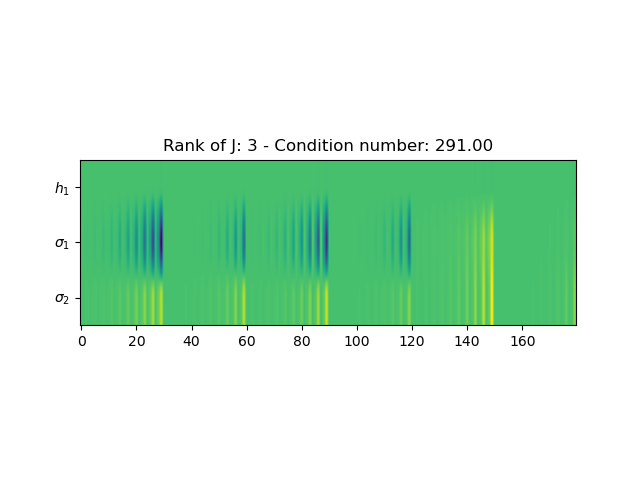

In [20]:
# Test for 2 layers

FOP = FDEM_1D(nlay = 2)

sigmas = [20/1000, 100/1000]
thicks = [2]

FOP.response(thicks + sigmas)

J = FOP.createJacobian(thicks + sigmas)

fig, ax = plt.subplots()

ax.imshow(np.array(J).T, aspect=20, interpolation=None)

#[HOP, HIP, VOP, VIP, POP, PIP]
xticks = ['H2 Q', 'H4 Q', 'H8 Q', 'V2 Q', 'V4 Q', 'V8 Q', 'P2 Q', 'P4 Q', 'P8 Q',
          'H2 IP', 'H4 IP', 'H8 IP', 'V2 IP', 'V4 IP', 'V8 IP', 'P2 IP', 'P4 IP', 'P8 IP' ]

yticks = ['$h_1$', '$\sigma_1$', '$\sigma_2$', ]

#ax.set_xticks(range(len(data)), labels=xticks, rotation = 90)
ax.set_yticks(range(3), labels=yticks)

ax.set_title('Rank of J: ' + str( np.linalg.matrix_rank(J)) +' - Condition number: %.2f' %np.linalg.cond(J) )

res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01]
depth: [ 0 -2 -5]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01]
depth: [ 0 -2 -5]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01]
depth: [ 0.     -2.0001 -5.0001]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01]
depth: [ 0.     -2.     -5.0001]
res:  [1.00000000e+06 4.97512438e+01 1.00000000e+01 3.33333333e+01]
depth: [ 0 -2 -5]
res:  [1.00000000e+06 5.00000000e+01 9.99000999e+00 3.33333333e+01]
depth: [ 0 -2 -5]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.32225914e+01]
depth: [ 0 -2 -5]


Text(0.5, 1.0, 'Rank of J: 5 - Condition number: 14795.00')

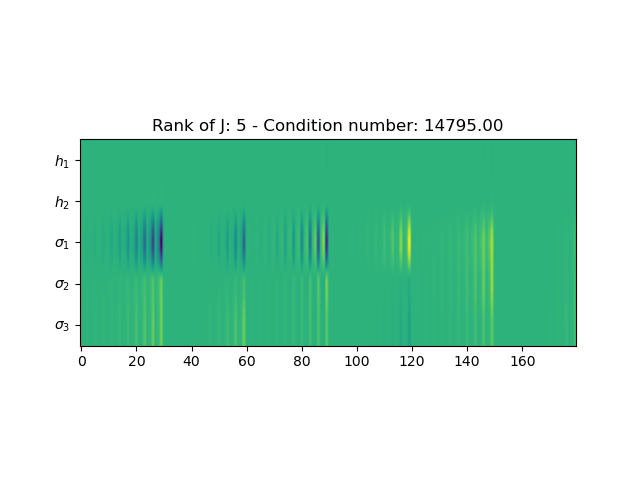

In [24]:
# Test for 3 layers

FOP = FDEM_1D(nlay = 3)

sigmas = [20/1000, 100/1000, 30/1000]
thicks = [2, 3]

FOP.response(thicks + sigmas)

J = FOP.createJacobian(thicks + sigmas)

fig, ax = plt.subplots()

ax.imshow(np.array(J).T, aspect=15)

#[HOP, HIP, VOP, VIP, POP, PIP]
xticks = ['H2 Q', 'H4 Q', 'H8 Q', 'V2 Q', 'V4 Q', 'V8 Q', 'P2 Q', 'P4 Q', 'P8 Q',
          'H2 IP', 'H4 IP', 'H8 IP', 'V2 IP', 'V4 IP', 'V8 IP', 'P2 IP', 'P4 IP', 'P8 IP' ]

yticks = ['$h_1$', '$h_2$', '$\sigma_1$', '$\sigma_2$', '$\sigma_3$', ]

#ax.set_xticks(range(len(data)), labels=xticks, rotation = 90)
ax.set_yticks(range(5), labels=yticks)

ax.set_title('Rank of J: ' + str( np.linalg.matrix_rank(J)) +' - Condition number: %.2f' %np.linalg.cond(J) )

res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01]
depth: [ 0 -1 -4 -6]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01]
depth: [ 0 -1 -4 -6]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01]
depth: [ 0.     -1.0001 -4.0001 -6.0001]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01]
depth: [ 0.     -1.     -4.0001 -6.0001]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01]
depth: [ 0.     -1.     -4.     -6.0001]
res:  [1.00000000e+06 4.97512438e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01]
depth: [ 0 -1 -4 -6]
res:  [1.00000000e+06 5.00000000e+01 9.99000999e+00 3.33333333e+01
 2.00000000e+01]
depth: [ 0 -1 -4 -6]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.32225914e+01
 2.00000000e+01]
depth: [ 0 -1 -4 -6]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 1.99600798e+01]
depth: [ 0 -1 -4

Text(0.5, 1.0, 'Rank of J: 7 - Condition number: 552175.15')

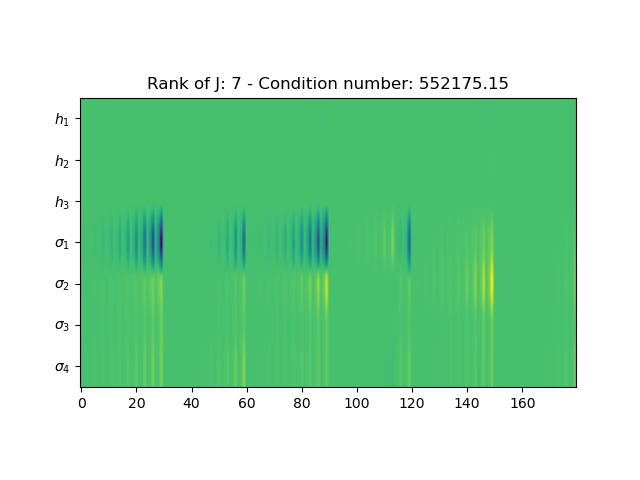

In [26]:
# Test for 4 layers

FOP = FDEM_1D(nlay = 4)

sigmas = [20/1000, 100/1000, 30/1000, 50/1000]
thicks = [1, 3, 2]

FOP.response(thicks + sigmas)

J = FOP.createJacobian(thicks + sigmas)

fig, ax = plt.subplots()

ax.imshow(np.array(J).T, aspect=15)

#[HOP, HIP, VOP, VIP, POP, PIP]
xticks = ['H2 Q', 'H4 Q', 'H8 Q', 'V2 Q', 'V4 Q', 'V8 Q', 'P2 Q', 'P4 Q', 'P8 Q',
          'H2 IP', 'H4 IP', 'H8 IP', 'V2 IP', 'V4 IP', 'V8 IP', 'P2 IP', 'P4 IP', 'P8 IP' ]

yticks = ['$h_1$', '$h_2$', '$h_3$', '$\sigma_1$', '$\sigma_2$', '$\sigma_3$', '$\sigma_4$', ]

#ax.set_xticks(range(len(data)), labels=xticks, rotation = 90)
ax.set_yticks(range(7), labels=yticks)

ax.set_title('Rank of J: ' + str( np.linalg.matrix_rank(J)) +' - Condition number: %.2f' %np.linalg.cond(J) )

res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01 1.00000000e+02]
depth: [ 0 -1 -4 -6 -7]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01 1.00000000e+02]
depth: [ 0 -1 -4 -6 -7]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01 1.00000000e+02]
depth: [ 0.     -1.0001 -4.0001 -6.0001 -7.0001]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01 1.00000000e+02]
depth: [ 0.     -1.     -4.0001 -6.0001 -7.0001]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01 1.00000000e+02]
depth: [ 0.     -1.     -4.     -6.0001 -7.0001]
res:  [1.00000000e+06 5.00000000e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01 1.00000000e+02]
depth: [ 0.     -1.     -4.     -6.     -7.0001]
res:  [1.00000000e+06 4.97512438e+01 1.00000000e+01 3.33333333e+01
 2.00000000e+01 1.00000000e+02]
depth: [ 0 -1 -4 -6 -7]
res:  [1.00000000e+06 5.00000000e+01 9.

Text(0.5, 1.0, 'Rank of J: 9 - Condition number: 64242731.77')

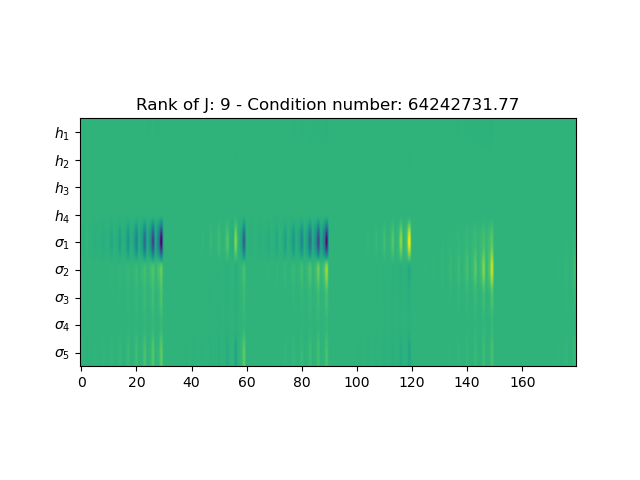

In [27]:
# Test for 5 layers

FOP = FDEM_1D(nlay = 5)

sigmas = [20/1000, 100/1000, 30/1000, 50/1000, 10/1000]
thicks = [1, 3, 2, 1]

FOP.response(thicks + sigmas)

J = FOP.createJacobian(thicks + sigmas)

fig, ax = plt.subplots()

ax.imshow(np.array(J).T,aspect=10)

#[HOP, HIP, VOP, VIP, POP, PIP]
xticks = ['H2 Q', 'H4 Q', 'H8 Q', 'V2 Q', 'V4 Q', 'V8 Q', 'P2 Q', 'P4 Q', 'P8 Q',
          'H2 IP', 'H4 IP', 'H8 IP', 'V2 IP', 'V4 IP', 'V8 IP', 'P2 IP', 'P4 IP', 'P8 IP' ]

yticks = ['$h_1$', '$h_2$', '$h_3$', '$h_4$', '$\sigma_1$', '$\sigma_2$', '$\sigma_3$', '$\sigma_4$', '$\sigma_5$', ]

#ax.set_xticks(range(len(data)), labels=xticks, rotation = 90)
ax.set_yticks(range(9), labels=yticks)

ax.set_title('Rank of J: ' + str( np.linalg.matrix_rank(J)) +' - Condition number: %.2f' %np.linalg.cond(J) )

In [28]:
U, S, Vt = np.linalg.svd(J)

In [29]:
S

array([3.19080983e+03, 8.94581892e+02, 2.42665186e+02, 6.14029744e+01,
       4.13349267e+00, 1.10726662e+00, 3.11396737e-02, 2.78697494e-03,
       4.96680285e-05])